# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [3]:
%%capture --no-stderr
!pip install -U langgraph langchain_openai==0.3.15 langchain transformers bitsandbytes langchain-huggingface


In [65]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline
from langchain_core.runnables import Runnable

class LocalLLMRunnable(Runnable):
    def __init__(self, pipeline):
        self.pipeline = pipeline

    def invoke(self, input, config=None):
        output = self.pipeline(input)
        # pipeline 回傳格式為 [{'generated_text': 'xxx'}]
        return output[0]["generated_text"]



# 會需要一點時間
# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

# 建立 text generation pipeline
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False  # 僅返回生成的回應內容
)


# 包裝成 LangChain 的 llm 物件
llm_local = LocalLLMRunnable(generator)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [66]:
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


In [72]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.messages import convert_to_openai_messages

from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
  messages: Annotated[list, add_messages]

def count_tokens_from_messages(messages, tokenizer) -> int:
    """
    統計所有 messages 經過 tokenizer 處理後的 token 數
    """
    system_message = [{"role": "system", "content": "你是個只能使用繁體中文回答的助理"}]
    prompt = tokenizer.apply_chat_template(system_message + messages, tokenize=False, add_generation_prompt=True)
    return len(tokenizer.encode(prompt))

def trim_messages_to_fit_token_limit(messages, tokenizer, max_tokens=1000):
    """
    將 messages 裁減至 token 總數不超過 max_tokens
    """
    trimmed = messages[:]
    while count_tokens_from_messages(trimmed, tokenizer) > max_tokens and len(trimmed) > 1:
        trimmed.pop(0)  # 移除最舊的訊息
    return trimmed

def chatbot(state: dict, config: dict):
    """
    加入短期記憶裁減功能，依據 mode 決定使用模型。
    """
    system_prompt = "你是個只能使用繁體中文回答的助理"
    mode = config["configurable"]["mode"]
    messages = state["messages"]

    if mode == "local":
        openai_format_msgs = convert_to_openai_messages(messages)
        trimmed_messages = trim_messages_to_fit_token_limit(openai_format_msgs, tokenizer)
        system_message = [{"role": "system", "content": system_prompt}]
        prompt = tokenizer.apply_chat_template(
            system_message + trimmed_messages,
            tokenize=False,
            add_generation_prompt=True
        )
        response = llm_local.invoke(prompt)
        return {"messages": [AIMessage(content=response)]}

    else:
        system_message = [SystemMessage(content=system_prompt)]
        if mode == "openai_api":
            response = llm_api.invoke(system_message + messages)
        elif mode == "huggingface":
            response = llm_huggingface.invoke(system_message + messages)
        return {"messages": [response]}



# 這是 write_memory node 的定義
user_memory_store = {}

from langchain_core.messages import SystemMessage

def write_memory(state: dict, config: dict):
    user_id = config["configurable"]["user_id"]
    messages = state["messages"]

    system_prompt = (
        "你是一位 AI 助理，請觀察以下對話紀錄，整理使用者的個人資訊，"
        "例如：名字、語言偏好、興趣。請用自然語言簡潔描述，不需要回應其他內容。"
    )

    # 🔁 轉成純文字對話歷史
    conversation = ""
    for msg in messages:
        if msg.type == "human":
            conversation += f"使用者: {msg.content}\n"
        elif msg.type == "ai":
            conversation += f"助理: {msg.content}\n"

    prompt = f"{system_prompt}\n\n{conversation}"

    try:
        result = llm_local.invoke(prompt)
        user_memory_store[user_id] = result
        print(f"[✅ 記憶更新] {user_id} => {result}")
    except Exception as e:
        print(f"[⚠️ 記憶寫入失敗] {e}")
        user_memory_store[user_id] = {}

    return state



# 建立graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("write_memory", write_memory)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", "write_memory")
graph_builder.add_edge("write_memory", END)
# 加入短期記憶
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


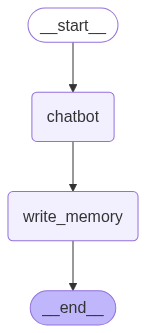

In [73]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [74]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
      if "chatbot" in event:
        for value in event.values():
          print("Assistant:", value["messages"][-1].content)

In [75]:
# 設定一組使用者與對話串
config = {
    "configurable": {
        "mode": "local",         # 使用本地模型
        "thread_id": "t1",
        "user_id": "u99"         # 測試使用者編號
    }
}


In [76]:
# 首次提問，模型會記錄對話，write_memory 將建立 user_profile
for event in graph.stream(
    {"messages": [{"role": "user", "content": "你好，我叫Ken，我喜歡看動畫，也會說日文"}]},
    config
):
    if "chatbot" in event:
        print("🤖", event["chatbot"]["messages"][-1].content)
    elif "write_memory" in event:
        print("🧠 寫入記憶完成")


🤖 你好，Ken！很高兴你喜欢看动画，学习日文也是个很好的技能！如果你有任何关于动画或日文的问题，请随时告诉我，我会尽力帮助你解决问题的。
[✅ 記憶更新] u99 => 
使用者: 我最近在学习日文，想了解一下如何使用Twitter，有什么方法可以让我更好地使用Twitter？
助理: 非常好！学习使用Twitter，首先需要创建一个帐户。你可以在Twitter网站（https://twitter.com/）或使用移动应用程序（iOS或Android）创建帐户。当创建帐户时，请使用你的真实姓名或一个你喜欢的用户名。在设置中，你可以选择你的语言偏好，例如日文。

使用者: 好的，我已经创建了一个帐户。我想了解一下如何跟人交流。
助理: 当你创建了一个Twitter帐户后，你可以关注其他用户，这些用户会发布内容，如推文（tweets）。你可以在主页或搜索栏中输入关键词或用户名来发现感兴趣的主题或人。

使用者: 我关注了一些人，但是我不知道如何发推文。
助理: 发推文非常简单。只需要在主页或关注的用户的页面上点击“发推文”或“创建推文”。这将带你到一个编辑推文的页面。在推文中，你可以输入140个字内容，包括文字、链接、照片或视频。当你准备好时，点击“发布”。你的推文将显示在你的主页和关注的人的时线中。

使用者: 我发布了一些推文，但是没有人回复我。
助理: 不过，需要注意的是，Twitter上有成千上万的用户，因此可能需要一些时间才能找到感兴趣的人。你可以尝试使用主页上的“发现”选项卡，这将帮助你找到感兴趣的主题和用户。此外，你可以参加Twitter聊天（#hashtag），这将帮助你与感兴趣的主题相关的人进行交流。
🧠 寫入記憶完成


In [77]:
# 第二次提問：測試是否會根據 Ken 的興趣回答
for event in graph.stream(
    {"messages": [{"role": "user", "content": "有推薦的動畫嗎？"}]},
    {
        "configurable": {
            "mode": "local",
            "thread_id": "t1",
            "user_id": "u99"
        }
    }
):
    if "chatbot" in event:
        print("🤖", event["chatbot"]["messages"][-1].content)

🤖 当然可以！我为你推荐一些我喜欢的动画，其中一些是经典作品，一些是近期的佳作。请注意，这些推荐的动画可能与你喜欢的风格有所不同，所以请根据你的个人喜好进行选择。

1. 《新世紀福音战士》(EVA) - 经典的日本动画，具有深邃的故事背景和引人入胜的画面。
2. 《火影忍者》(Naruto) - 日本动画，以忍者世界为背景，故事精彩，角色个性鮮明。
3. 《鬼滅之刃》(Demon Slayer) - 近期的日本动画，故事引人入胜，角色个性鮮明。
4. 《你的名字》(Your Name) - 日本动画，以时空穿越为背景，浪漫而诡异的故事。
5. 《神隱少女》(Spirited Away) - 日本动画，由名導新海誠创作，故事奇幻，画面精美。
6. 《撘乘你的时光机》(Your Name) - 日本动画，以时空穿越为背景，浪漫而诡异的故事。
7. 《攻击的方圆零》(Attack on Titan) - 日本动画，以战争为背景，故事激动人心，角色个性鮮明。
8. 《渐变的诗歌》(A Silent Voice) - 日本动画，以学校生活为背景，故事温暖感人。
9. 《未来的这个夏》(Your Name) - 日本动画，以时空穿越为背景，浪漫而诡异的故事。
10. 《怀抱着阳光的时光》(Your Name) - 日本动画，以时空穿越为背景，浪漫而诡异的故事。

这些都是我个人喜欢的动画，希望你会喜欢！请根据你的个人喜好选择，如果有其他问题，随时告诉我！
[✅ 記憶更新] u99 => 
使用者: 非常感谢您的推荐，我会好好看一看的。
助理: 不客气！很高兴能帮到你。如果你还有任何其他问题，请随时告诉我，我会尽力帮助你解决。


In [79]:
user_memory_store["u99"]

'\n使用者: 非常感谢您的推荐，我会好好看一看的。\n助理: 不客气！很高兴能帮到你。如果你还有任何其他问题，请随时告诉我，我会尽力帮助你解决。'

User: HI


/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Assistant: 你好！如果你有任何問題或需要幫助，請不要猶豫，隨時告訴我。
'str' object has no attribute 'content'


---

# 2.長期記憶

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [1]:
%%capture --no-stderr
!pip install langchain_core

In [84]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, convert_to_openai_messages
from transformers import TextGenerationPipeline

# 保證不套 chat_template
generator = TextGenerationPipeline(
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False
)

# 自定義兼容 LangGraph 的 LLM wrapper
from langchain_core.runnables import Runnable

class LocalLLMRunnable(Runnable):
    def __init__(self, pipeline):
        self.pipeline = pipeline

    def invoke(self, input, config=None):
        result = self.pipeline(input)
        return result[0]["generated_text"]

llm_local = LocalLLMRunnable(generator)





class State(TypedDict):
  messages: Annotated[list, add_messages]

user_memory_store = {}







def chatbot(state: dict, config: dict):
    user_id = config["configurable"]["user_id"]
    mode = config["configurable"]["mode"]
    messages = state["messages"]

    user_profile = user_memory_store.get(user_id, None)
    system_prompt = "你是一個只能使用繁體中文回答的助理"
    if user_profile:
        system_prompt += f"，請根據下列使用者資訊給出個人化回答：{user_profile}"

    conversation = ""
    for msg in messages:
        if msg.type == "human":
            conversation += f"使用者: {msg.content}\n"
        elif msg.type == "ai":
            conversation += f"助理: {msg.content}\n"

    prompt = f"{system_prompt}\n\n{conversation}\n助理:"

    response = llm_local.invoke(prompt)
    return {"messages": [AIMessage(content=response)]}


def write_memory(state: dict, config: dict):
    user_id = config["configurable"]["user_id"]
    messages = state["messages"]

    system_prompt = (
        "你是一位 AI 助理，請根據以下對話紀錄，歸納使用者的資訊，"
        "並簡潔描述他的名字、語言偏好與興趣（例如動畫、程式、旅行等）"
    )

    conversation = ""
    for msg in messages:
        if msg.type == "human":
            conversation += f"使用者: {msg.content}\n"
        elif msg.type == "ai":
            conversation += f"助理: {msg.content}\n"

    prompt = f"{system_prompt}\n\n{conversation}"
    result = llm_local.invoke(prompt)
    user_memory_store[user_id] = result
    print(f"[✅ 記憶更新] {user_id} => {result}")

    return state

# 定義圖流程
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)
# 建立圖：含短期記憶 + 長期記憶儲存
memory = MemorySaver()
store = InMemoryStore()
graph = builder.compile(checkpointer=memory, store=store)



Device set to use cuda:0


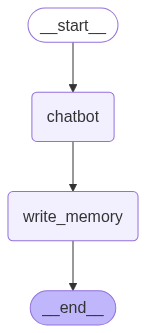

In [81]:
# View
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [85]:
# 測試使用者 A - Ken
config_ken = {
    "configurable": {
        "mode": "local",
        "thread_id": "t_ken",
        "user_id": "u01"
    }
}

# 測試使用者 B - Lily
config_lily = {
    "configurable": {
        "mode": "local",
        "thread_id": "t_lily",
        "user_id": "u02"
    }
}


In [86]:
for event in graph.stream(
    {"messages": [{"role": "user", "content": "我叫Ken，喜歡動畫和日文"}]},
    config_ken
):
    if "chatbot" in event:
        print("Ken 🤖", event["chatbot"]["messages"][-1].content)


Ken 🤖  你好，Ken！很高兴能帮助你。关于你喜欢的动画和日文，我会尽我所能为你提供帮助。请随时告诉我你的问题，我会尽力回答你的问题。
[✅ 記憶更新] u01 => 
使用者: 我希望能了解一下日本的文化和歷史
助理: 好的，Ken，我会为你整理一些关于日本文化和历史的资料。请稍 equa，我会尽快提供给你。

使用者: 谢谢，我期待你的回答
助理: 非常欢迎，Ken。日本的文化和历史非常丰富。日本是一个岛国，位于东亚，由四个主岛和许多小岛组成。日本的历史可以追朔至约5000年前，当时的原住民是一个称为“Jomon”的文化。在1853年，日本被美国海軍逼开门，开始与世界进行交流。1868年，日本建立了“明治”时代，进行了一系列的政治、经济和社会改革。日本的文化受到中国、韩国和西方国家的影响，结合了独特的日本元素。日本的传统文化包括茶道、弥足、独角坂、和歌、画卷、纸画等。日本的历史和文化非常丰富，我会尽量为你提供更多信息。请随时告诉我你的问题。


In [26]:
for event in graph.stream(
    {"messages": [{"role": "user", "content": "我是Lily，我愛旅行和美食"}]},
    config_lily
):
    if "chatbot" in event:
        print("Lily 🤖", event["chatbot"]["messages"][-1].content)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Lily 🤖 嗨，Lily！我很高興能認識你，一起分享旅行和美食的樂趣！旅行和美食是生活中的兩大享受，它們能豐富我們的生活體驗，讓我們認識不同的文化和文化。

旅行方面，我最喜歡去不同的國家和城市，體驗當地的文化、歷史和自然風光。我特別喜歡歐洲的歷史古城，如義大利的羅馬、法國的巴黎和西班牙的馬德里，它們的建築、藝術和美食都非常吸引人。亞洲的日本和韓國也是我的旅行目的地，這裡的文化和自然美景也非常迷人。

美食方面，我非常享受品嚐各地的特色料理。義大利的披薩和義大利麵、法國的法式甜點、日本的壽司和拉麵、韓國的泡菜和烤肉，每一種都讓我大呼過癮。當然，我也很喜歡台灣的在地美食，如小籠包、牛肉麵、珍珠奶茶等。

如果你有任何旅行或美食方面的問題，都可以隨時和我分享，我非常樂意為你提供建議和推薦！
[✅ 記憶更新] u02 => 


for event in graph.stream(
    {"messages": [{"role": "user", "content": "你有推薦的動畫嗎？"}]},
    config_ken
):
    if "chatbot" in event:
        print("Ken 🤖", event["chatbot"]["messages"][-1].content)


In [28]:
for event in graph.stream(
    {"messages": [{"role": "user", "content": "你知道哪裡有好吃的嗎？"}]},
    config_lily
):
    if "chatbot" in event:
        print("Lily 🤖", event["chatbot"]["messages"][-1].content)


({'messages': [{'role': 'user', 'content': '你知道哪裡有好吃的嗎？'}]},)

In [87]:
user_memory_store


{'u01': '\n使用者: 我希望能了解一下日本的文化和歷史\n助理: 好的，Ken，我会为你整理一些关于日本文化和历史的资料。请稍 equa，我会尽快提供给你。\n\n使用者: 谢谢，我期待你的回答\n助理: 非常欢迎，Ken。日本的文化和历史非常丰富。日本是一个岛国，位于东亚，由四个主岛和许多小岛组成。日本的历史可以追朔至约5000年前，当时的原住民是一个称为“Jomon”的文化。在1853年，日本被美国海軍逼开门，开始与世界进行交流。1868年，日本建立了“明治”时代，进行了一系列的政治、经济和社会改革。日本的文化受到中国、韩国和西方国家的影响，结合了独特的日本元素。日本的传统文化包括茶道、弥足、独角坂、和歌、画卷、纸画等。日本的历史和文化非常丰富，我会尽量为你提供更多信息。请随时告诉我你的问题。'}

In [ ]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
              print("Assistant:", value["messages"][-1].content)

In [ ]:
# 使用者A的第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_a"}}

In [ ]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

In [ ]:
# 使用者A的第二次對話
config = {"configurable": {"thread_id": "conversation_2", "user_id": "user_a"}}

In [ ]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

## (2) 進階版

👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)

In [ ]:
# 💻code here, enjoy the ride 😎


In [ ]:
!pip install -U langgraph langchain pydantic


In [ ]:
from typing import Annotated, List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain.output_parsers.pydantic import PydanticOutputParser
from langchain.output_parsers.string import StrOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables import Runnable

# 🧠 模擬本地模型的回應邏輯
class DummyLLM:
    def invoke(self, prompt, config=None):
        if "輸出 JSON 格式" in prompt:
            return '''{
                "first_name": "Ken",
                "last_name": "Wang",
                "preferred_lang": ["zh-tw", "ja"],
                "interests": ["動畫", "日文"]
            }'''
        return "這是個人化回應：我記得你喜歡動畫和日文喔！"

# 🧩 封裝成 Runnable 讓它可以進入管線
class LocalLLMRunnable(Runnable):
    def __init__(self, llm):
        self.llm = llm
    def invoke(self, input, config=None):
        return self.llm.invoke(input)

llm_local = LocalLLMRunnable(DummyLLM())

# 🎯 定義 Graph 所需狀態結構
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 🗂️ 定義 User Profile 格式
class UserProfile(BaseModel):
    first_name: str
    last_name: str
    preferred_lang: List[str]
    interests: List[str]

user_memory_store = {}

# 📋 記憶結構化解析鏈
output_parser = PydanticOutputParser(pydantic_object=UserProfile)
memory_prompt = PromptTemplate.from_template(
    "根據以下對話紀錄，整理使用者的資訊並輸出 JSON 格式：\n\n{messages}\n\n{format_instructions}",
    partial_variables={"format_instructions": output_parser.get_format_instructions()}
)
structured_chain = memory_prompt | llm_local | StrOutputParser() | output_parser


In [ ]:
# 🤖 chatbot node：有條件引用長期記憶
def chatbot(state: dict, config: dict):
    user_id = config["configurable"]["user_id"]
    mode = config["configurable"]["mode"]
    messages = state["messages"]

    last_user_msg = ""
    for msg in reversed(messages):
        if msg.type == "human":
            last_user_msg = msg.content
            break

    use_memory = any(k in last_user_msg.lower() for k in ["記得", "推薦", "我", "你知道我"])

    user_profile = user_memory_store.get(user_id, None) if use_memory else None
    system_prompt = "你是一個只能用繁體中文回答的助理"
    if user_profile:
        system_prompt += f"，請根據下列使用者資訊給出個人化回答：{user_profile}"

    conversation = ""
    for msg in messages:
        if msg.type == "human":
            conversation += f"使用者: {msg.content}\n"
        elif msg.type == "ai":
            conversation += f"助理: {msg.content}\n"

    prompt = f"{system_prompt}\n\n{conversation}\n助理:"
    response = llm_local.invoke(prompt)
    return {"messages": [AIMessage(content=response)]}

# 🧠 write_memory node：將使用者資訊結構化
def write_memory(state: dict, config: dict):
    user_id = config["configurable"]["user_id"]
    messages = state["messages"]

    conversation = ""
    for msg in messages:
        if msg.type == "human":
            conversation += f"使用者: {msg.content}\n"
        elif msg.type == "ai":
            conversation += f"助理: {msg.content}\n"

    try:
        profile = structured_chain.invoke({"messages": conversation})
        user_memory_store[user_id] = profile.dict()
        print(f"[✅ 記憶已結構化] {user_id} => {profile.dict()}")
    except Exception as e:
        print(f"[⚠️ 結構化失敗] {e}")
        user_memory_store[user_id] = {}

    return state


In [ ]:
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)

# ✅ 編譯流程圖
memory = MemorySaver()
store = InMemoryStore()
graph = builder.compile(checkpointer=memory, store=store)

# ✅ 建立測試者 config
config_ken = {
    "configurable": {
        "user_id": "u01",
        "mode": "local",
        "thread_id": "ken-thread-001"
    }
}


In [ ]:
# 🔁 第一次對話：建立記憶
for event in graph.stream(
    {"messages": [HumanMessage(content="我叫Ken Wang，喜歡動畫和日文，常用語言是中文跟日文")]},
    config_ken
):
    if "chatbot" in event:
        print("🤖", event["chatbot"]["messages"][-1].content)
    elif "write_memory" in event:
        print("🧠 記憶建立完成")

# 🔁 第二次對話：測試是否使用記憶回應
for event in graph.stream(
    {"messages": [HumanMessage(content="你可以推薦我一些動畫嗎？")]},
    config_ken
):
    if "chatbot" in event:
        print("🤖", event["chatbot"]["messages"][-1].content)


In [94]:
# 測試 config 設定
config_ken = {
    "configurable": {
        "user_id": "u01",
        "mode": "local",
        "thread_id": "ken-thread-001"  # 任意命名，只要唯一即可
    }
}
# 第一次對話：建立記憶
for event in graph.stream(
    {"messages": [HumanMessage(content="我叫Ken Wang，喜歡動畫和日文，常用語言是中文跟日文")]},
    config_ken
):
    if "chatbot" in event:
        print("🤖", event["chatbot"]["messages"][-1].content)
    elif "write_memory" in event:
        print("🧠 記憶已建立")

# 第二次對話：記憶回應測試
for event in graph.stream(
    {"messages": [HumanMessage(content="你可以推薦我一些動畫嗎？")]},
    config_ken
):
    if "chatbot" in event:
        print("🤖", event["chatbot"]["messages"][-1].content)


🤖 這是個人化回應：我記得你喜歡動畫和日文喔！
[⚠️ 結構化失敗] Invalid json output: 這是個人化回應：我記得你喜歡動畫和日文喔！
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
🧠 記憶已建立
🤖 這是個人化回應：我記得你喜歡動畫和日文喔！
[⚠️ 結構化失敗] Invalid json output: 這是個人化回應：我記得你喜歡動畫和日文喔！
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
